## This is an example script used for the bulk RNA transcriptomic cohort analysis
It uses R

In [2]:
# load all the required packages (already in the RNA R yaml environment provided in the directory)
library(gplots)
library(RColorBrewer)
library(tximport)
library(ggplot2)
library(DESeq2)
library(GenomicFeatures)
library(readr)
library(rtracklayer)
library(ggrepel)
library(limma)
library(tidyverse)
library(tidyr)
library(fgsea)
library(msigdbr)
library(org.Hs.eg.db)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:gplots’:

    space


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from 

In [3]:
rm(list = ls())  # this clears the environment of any variables, old plots, that kind of thing
# fetching files
getwd()


[1] "/nfs/users/nfs_l/lr26/shells"

In [4]:
# firstly I need to format the feature table in order to be able to work with tximport
feature_file <- "/lustre/scratch126/cellgen/behjati/lr26/T2T/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt.gz"
feature_table <- read.delim(feature_file, header = TRUE, sep = "\t", quote = "")

# look for the features
names(feature_table)  # X..feature, gene ID, etc
# check unique values 
unique(feature_table$`X..feature`)

# since this is transcriptomics, I subset for transcripts using the correct name of the column and filter for transcripts
tx2gene_df <- subset(feature_table, 
                     `X..feature` %in% c("mRNA", "ncRNA") & 
                     !is.na(GeneID) & 
                     !is.na(product_accession))

# confirm that I have the resulting df
head(tx2gene_df)
nrow(tx2gene_df)

# create the tx2gene mapping
tx2gene <- tx2gene_df[, c("product_accession", "symbol")]
colnames(tx2gene) <- c("transcript_id", "geneID")

# check it makes sense
head(tx2gene)
nrow(tx2gene)
class(tx2gene)
tx2gene[1:30,]


[1] "X..feature"              "class"                  
 [3] "assembly"                "assembly_unit"          
 [5] "seq_type"                "chromosome"             
 [7] "genomic_accession"       "start"                  
 [9] "end"                     "strand"                 
[11] "product_accession"       "non.redundant_refseq"   
[13] "related_accession"       "name"                   
[15] "symbol"                  "GeneID"                 
[17] "locus_tag"               "feature_interval_length"
[19] "product_length"          "attributes"

[1] "gene"          "ncRNA"         "mRNA"          "CDS"          
 [5] "precursor_RNA" "misc_RNA"      "tRNA"          "V_segment"    
 [9] "rRNA"          "C_region"      "J_segment"     "D_segment"

,X..feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<int>,<lgl>,<int>,<int>,<chr>
2,ncRNA,lncRNA,GCF_009914755.1,Primary Assembly,chromosome,1,NC_060925.1,7506,138480,-,NR_182074.1,NA,,"uncharacterized lncRNA, transcript variant 1",LOC127239154,127239154,NA,5892,5901,
3,ncRNA,lncRNA,GCF_009914755.1,Primary Assembly,chromosome,1,NC_060925.1,7506,137287,-,NR_182075.1,NA,,"uncharacterized lncRNA, transcript variant 2",LOC127239154,127239154,NA,5829,5838,
4,ncRNA,lncRNA,GCF_009914755.1,Primary Assembly,chromosome,1,NC_060925.1,7506,13582,-,NR_182076.1,NA,,"uncharacterized lncRNA, transcript variant 3",LOC127239154,127239154,NA,5615,5733,partial
6,ncRNA,lncRNA,GCF_009914755.1,Primary Assembly,chromosome,1,NC_060925.1,20892,23710,-,XR_007069731.1,NA,,uncharacterized lncRNA,LOC124905685,124905685,NA,283,283,
8,ncRNA,lncRNA,GCF_009914755.1,Primary Assembly,chromosome,1,NC_060925.1,52979,54612,-,NR_125957.1,NA,,uncharacterized lncRNA,LOC101928626,101928626,NA,802,798,
10,mRNA,,GCF_009914755.1,Primary Assembly,chromosome,1,NC_060925.1,111940,112877,-,NM_001005277.1,NA,NP_001005277.1,olfactory receptor family 4 subfamily F member 16,OR4F16,81399,NA,938,939,


[1] 165711

,transcript_id,geneID
,<chr>,<chr>
2,NR_182074.1,LOC127239154
3,NR_182075.1,LOC127239154
4,NR_182076.1,LOC127239154
6,XR_007069731.1,LOC124905685
8,NR_125957.1,LOC101928626
10,NM_001005277.1,OR4F16


[1] 165711

[1] "data.frame"

,transcript_id,geneID
,<chr>,<chr>
2,NR_182074.1,LOC127239154
3,NR_182075.1,LOC127239154
4,NR_182076.1,LOC127239154
6,XR_007069731.1,LOC124905685
8,NR_125957.1,LOC101928626
10,NM_001005277.1,OR4F16
15,NR_168328.1,LOC100288069
18,NR_187359.1,LINC01409
20,NR_103536.1,FAM87B


In [8]:
# here I take a list of the files in the Salmon directory, all should be named with a pattern quant.sf
files <- list.files(path = "/lustre/scratch126/cellgen/behjati/lr26/RNA/Salmon",
                    pattern = "quant.sf", full.names = TRUE, recursive = TRUE)

# keep only files in folders starting with quant_te (all are in their respective folders and start with quant_te)
files <- files[grepl("quant_te", files)]

# I am using the parent folder name as sample name
names(files) <- sub("^quant_te[_-]?", "", basename(dirname(files)))

In [9]:
# here is the actual tximport with salmon 
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, countsFromAbundance = "no")

# I observe the result, rownames and counts, and abundance
head(txi$counts)
head(txi$abundance)
head(rownames(txi$counts))
head(rownames(txi$abundance))


reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 16267

summarizing abundance

summarizing counts

summarizing length



,AS-892475-LR-66487,AS-892476-LR-66487,AS-892477-LR-66487,AS-892478-LR-66487,AS-892479-LR-66487,AS-892480-LR-66487,AS-892481-LR-66487,AS-892482-LR-66487,AS-892483-LR-66487,AS-892484-LR-66487,⋯,GSM5024895,GSM5024896,GSM5024897,GSM5024898,GSM5024899,GSM5024900,GSM5024901,GSM5024902,our_patient_FO,our_patient
A1BG,605.280,185.000,473.000,221.000,520.693,185.000,519,499.000,322.997,458.000,⋯,433.326,264.773,188.205,237.917,216.427,94.786,316.258,250.127,379.094,1102.000
A1BG-AS1,260.000,280.000,527.000,534.000,667.000,244.000,416,483.000,812.218,331.000,⋯,176.125,134.448,55.030,151.060,135.841,24.000,95.789,92.002,538.000,368.004
A1CF,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,⋯,32.000,22.737,48.224,4.014,7.000,5.000,85.982,2.018,3.000,2.000
A2M,1.000,15590.361,3.000,17.000,33.000,387.012,22,4373.988,43.000,22809.281,⋯,4101.929,667.506,175.696,5904.509,19216.217,35.000,78907.266,5586.056,20044.608,89773.440
A2M-AS1,2.000,1.000,0.000,2.000,3.000,1.000,21,64.000,56.000,186.999,⋯,38.000,29.001,14.296,15.000,78.219,81.000,130.965,35.000,429.000,1032.000
A2ML1,3153.327,140.151,365.155,290.001,2363.429,102.000,1,1.000,0.000,2.000,⋯,169.923,73.162,101.742,26.821,53.203,57.106,169.836,66.451,277.804,0.000


,AS-892475-LR-66487,AS-892476-LR-66487,AS-892477-LR-66487,AS-892478-LR-66487,AS-892479-LR-66487,AS-892480-LR-66487,AS-892481-LR-66487,AS-892482-LR-66487,AS-892483-LR-66487,AS-892484-LR-66487,⋯,GSM5024895,GSM5024896,GSM5024897,GSM5024898,GSM5024899,GSM5024900,GSM5024901,GSM5024902,our_patient_FO,our_patient
A1BG,2.805035,1.545213,2.548477,1.988391,3.259987,1.616629,3.343938,3.664909,2.502667,3.738633,⋯,4.247215,3.029634,6.896041,1.652471,1.407915,5.830983,2.028338,1.628097,2.398403,0.651409
A1BG-AS1,1.972893,3.835724,4.646404,7.860161,6.831876,3.490618,4.387505,5.807890,10.328153,4.424743,⋯,2.840377,2.509917,3.279103,1.718076,1.448706,2.419401,1.006925,0.978296,5.671335,0.362679
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.112761,0.094331,0.627962,0.010072,0.016248,0.111033,0.199022,0.004757,0.006740,0.000420
A2M,0.003480,92.904836,0.010866,0.114886,0.138905,2.404741,0.106444,22.948297,0.223635,132.699255,⋯,28.541735,5.476694,4.640494,29.379797,88.998892,1.481418,359.413217,25.987146,90.362768,37.721038
A2M-AS1,0.014741,0.013305,0.000000,0.027088,0.029849,0.013896,0.215142,0.715146,0.668041,2.314122,⋯,0.568063,0.505444,0.827867,0.162914,0.767236,7.574698,1.266260,0.342547,4.387024,0.948677
A2ML1,9.801793,0.761766,1.301877,1.738657,9.646109,0.608682,0.004522,0.005154,0.000000,0.010594,⋯,1.159268,0.605212,2.648110,0.128342,0.247267,2.400480,0.750221,0.307704,1.215415,0.000000


[1] "A1BG"     "A1BG-AS1" "A1CF"     "A2M"      "A2M-AS1"  "A2ML1"

[1] "A1BG"     "A1BG-AS1" "A1CF"     "A2M"      "A2M-AS1"  "A2ML1"

In [10]:
# here I am manually creating a metadata dataframe and I just add more whenever a new study comes in 
# sample id condition and study order must matched otherwise erros and messy
metadata <- data.frame(
  SampleID = c(
               "AS-892475-LR-66487", "AS-892476-LR-66487", "AS-892477-LR-66487", "AS-892478-LR-66487", 
               "AS-892479-LR-66487", "AS-892480-LR-66487", "AS-892481-LR-66487", "AS-892482-LR-66487", 
               "AS-892483-LR-66487", "AS-892484-LR-66487", "AS-893415-LR-66487", "GSM5024895", 
               "GSM5024896", "GSM5024897", "GSM5024898", "GSM5024899", "GSM5024900", 
               "GSM5024901", "GSM5024902", "our_patient_FO", "our_patient"),
  Condition = c("Ewing sarcoma", "Ewing sarcoma", "Ewing sarcoma",
                "Ewing sarcoma", "Ewing sarcoma", "Ewing sarcoma", "CIC-DUX4 sarcoma",
                "CIC-DUX4 sarcoma", "CIC-DUX4 sarcoma", "CIC-DUX4 sarcoma", "CIC-DUX4 sarcoma", 
                "CIC-DUX4 sarcoma", "Ewing sarcoma", "CIC-DUX4 sarcoma", "CIC-DUX4 sarcoma", 
                "Ewing sarcoma", "Ewing sarcoma", "Ewing sarcoma", "Ewing sarcoma", 
                "CIC-DUX4 sarcoma", "CIC-DUX4 sarcoma"),
  Study = c("Swiss", "Swiss", "Swiss", "Swiss", "Swiss", "Swiss", 
            "Swiss", "Swiss", "Swiss", "Swiss", "Swiss", "Italy", "Italy", 
            "Italy", "Italy", "Italy",
            "Italy", "Italy", "Italy", "UK", "UK"),
  stringsAsFactors = FALSE
)

# view the metadata
print(metadata)


             SampleID        Condition Study
1  AS-892475-LR-66487    Ewing sarcoma Swiss
2  AS-892476-LR-66487    Ewing sarcoma Swiss
3  AS-892477-LR-66487    Ewing sarcoma Swiss
4  AS-892478-LR-66487    Ewing sarcoma Swiss
5  AS-892479-LR-66487    Ewing sarcoma Swiss
6  AS-892480-LR-66487    Ewing sarcoma Swiss
7  AS-892481-LR-66487 CIC-DUX4 sarcoma Swiss
8  AS-892482-LR-66487 CIC-DUX4 sarcoma Swiss
9  AS-892483-LR-66487 CIC-DUX4 sarcoma Swiss
10 AS-892484-LR-66487 CIC-DUX4 sarcoma Swiss
11 AS-893415-LR-66487 CIC-DUX4 sarcoma Swiss
12         GSM5024895 CIC-DUX4 sarcoma Italy
13         GSM5024896    Ewing sarcoma Italy
14         GSM5024897 CIC-DUX4 sarcoma Italy
15         GSM5024898 CIC-DUX4 sarcoma Italy
16         GSM5024899    Ewing sarcoma Italy
17         GSM5024900    Ewing sarcoma Italy
18         GSM5024901    Ewing sarcoma Italy
19         GSM5024902    Ewing sarcoma Italy
20     our_patient_FO CIC-DUX4 sarcoma    UK
21        our_patient CIC-DUX4 sarcoma    UK


In [11]:
# I round the counts 
counts <- txi$counts
counts_rounded <- round(txi$counts)
# check how it looks
head(counts_rounded)
# I perform basic filtering of transcripts which have very low counts
logic <- rowSums(counts_rounded) > 10
counts_rounded <- counts_rounded[logic,]

# I check how filtered counts look
dim(counts_rounded)
counts_rounded[1:10, 1:6]
summary(counts_rounded)
dim(metadata)
print(metadata)

,AS-892475-LR-66487,AS-892476-LR-66487,AS-892477-LR-66487,AS-892478-LR-66487,AS-892479-LR-66487,AS-892480-LR-66487,AS-892481-LR-66487,AS-892482-LR-66487,AS-892483-LR-66487,AS-892484-LR-66487,⋯,GSM5024895,GSM5024896,GSM5024897,GSM5024898,GSM5024899,GSM5024900,GSM5024901,GSM5024902,our_patient_FO,our_patient
A1BG,605,185,473,221,521,185,519,499,323,458,⋯,433,265,188,238,216,95,316,250,379,1102
A1BG-AS1,260,280,527,534,667,244,416,483,812,331,⋯,176,134,55,151,136,24,96,92,538,368
A1CF,0,0,0,0,0,0,0,0,0,0,⋯,32,23,48,4,7,5,86,2,3,2
A2M,1,15590,3,17,33,387,22,4374,43,22809,⋯,4102,668,176,5905,19216,35,78907,5586,20045,89773
A2M-AS1,2,1,0,2,3,1,21,64,56,187,⋯,38,29,14,15,78,81,131,35,429,1032
A2ML1,3153,140,365,290,2363,102,1,1,0,2,⋯,170,73,102,27,53,57,170,66,278,0


[1] 32479    21

,AS-892475-LR-66487,AS-892476-LR-66487,AS-892477-LR-66487,AS-892478-LR-66487,AS-892479-LR-66487,AS-892480-LR-66487
A1BG,605,185,473,221,521,185
A1BG-AS1,260,280,527,534,667,244
A1CF,0,0,0,0,0,0
A2M,1,15590,3,17,33,387
A2M-AS1,2,1,0,2,3,1
A2ML1,3153,140,365,290,2363,102
A2ML1-AS1,0,0,0,0,0,0
A3GALT2,0,0,0,0,3,0
A4GALT,1586,61,4544,240,6054,2830
A4GNT,0,0,1,0,0,0


 AS-892475-LR-66487 AS-892476-LR-66487 AS-892477-LR-66487 AS-892478-LR-66487
 Min.   :      0    Min.   :      0    Min.   :      0    Min.   :      0   
 1st Qu.:      0    1st Qu.:      0    1st Qu.:      0    1st Qu.:      0   
 Median :     12    Median :      9    Median :     15    Median :     14   
 Mean   :   2994    Mean   :   1985    Mean   :   2637    Mean   :   1862   
 3rd Qu.:   1333    3rd Qu.:    955    3rd Qu.:   1165    3rd Qu.:   1071   
 Max.   :3089260    Max.   :1500140    Max.   :4500105    Max.   :1432328   
 AS-892479-LR-66487 AS-892480-LR-66487 AS-892481-LR-66487 AS-892482-LR-66487
 Min.   :      0    Min.   :      0    Min.   :      0    Min.   :      0   
 1st Qu.:      0    1st Qu.:      0    1st Qu.:      0    1st Qu.:      0   
 Median :     17    Median :     10    Median :     10    Median :     15   
 Mean   :   2732    Mean   :   1967    Mean   :   2394    Mean   :   2347   
 3rd Qu.:   1441    3rd Qu.:   1048    3rd Qu.:   1045    3rd Qu.:   1211   

[1] 21  3

             SampleID        Condition Study
1  AS-892475-LR-66487    Ewing sarcoma Swiss
2  AS-892476-LR-66487    Ewing sarcoma Swiss
3  AS-892477-LR-66487    Ewing sarcoma Swiss
4  AS-892478-LR-66487    Ewing sarcoma Swiss
5  AS-892479-LR-66487    Ewing sarcoma Swiss
6  AS-892480-LR-66487    Ewing sarcoma Swiss
7  AS-892481-LR-66487 CIC-DUX4 sarcoma Swiss
8  AS-892482-LR-66487 CIC-DUX4 sarcoma Swiss
9  AS-892483-LR-66487 CIC-DUX4 sarcoma Swiss
10 AS-892484-LR-66487 CIC-DUX4 sarcoma Swiss
11 AS-893415-LR-66487 CIC-DUX4 sarcoma Swiss
12         GSM5024895 CIC-DUX4 sarcoma Italy
13         GSM5024896    Ewing sarcoma Italy
14         GSM5024897 CIC-DUX4 sarcoma Italy
15         GSM5024898 CIC-DUX4 sarcoma Italy
16         GSM5024899    Ewing sarcoma Italy
17         GSM5024900    Ewing sarcoma Italy
18         GSM5024901    Ewing sarcoma Italy
19         GSM5024902    Ewing sarcoma Italy
20     our_patient_FO CIC-DUX4 sarcoma    UK
21        our_patient CIC-DUX4 sarcoma    UK


In [14]:
# here I am running the deseq2 analysis using the rounded count data 
# and using study as a covariate to correct batch effects
dds <- DESeqDataSetFromMatrix(countData = counts_rounded,
                                  colData = metadata,
                                  design = ~ Study + Condition)
#look at dds
dds
dim(dds)
class(dds)
colData(dds) #

# get normalised count matrix
dds <- DESeq(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 32479 21 
metadata(1): version
assays(1): counts
rownames(32479): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(21): AS-892475-LR-66487 AS-892476-LR-66487 ... our_patient_FO
  our_patient
colData names(3): SampleID Condition Study

[1] 32479    21

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

DataFrame with 21 rows and 3 columns
                             SampleID        Condition    Study
                          <character>         <factor> <factor>
AS-892475-LR-66487 AS-892475-LR-66487    Ewing sarcoma    Swiss
AS-892476-LR-66487 AS-892476-LR-66487    Ewing sarcoma    Swiss
AS-892477-LR-66487 AS-892477-LR-66487    Ewing sarcoma    Swiss
AS-892478-LR-66487 AS-892478-LR-66487    Ewing sarcoma    Swiss
AS-892479-LR-66487 AS-892479-LR-66487    Ewing sarcoma    Swiss
...                               ...              ...      ...
GSM5024900                 GSM5024900 Ewing sarcoma       Italy
GSM5024901                 GSM5024901 Ewing sarcoma       Italy
GSM5024902                 GSM5024902 Ewing sarcoma       Italy
our_patient_FO         our_patient_FO CIC-DUX4 sarcoma    UK   
our_patient               our_patient CIC-DUX4 sarcoma    UK   

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



In [15]:
# here I am performing variance stabilizing transformation
vsd <- vst(dds, blind = FALSE)

# and get a gene expression matrix
exprs.data=assay(vsd)

# which I can look at
exprs.data[1:3,1:3]


,AS-892475-LR-66487,AS-892476-LR-66487,AS-892477-LR-66487
A1BG,8.523769,7.419680,8.310677
A1BG-AS1,7.451612,7.931346,8.452532
A1CF,3.981119,3.981119,3.981119


In [16]:
# PCA is better shown with limma which handles batch correction 
corrected <- limma::removeBatchEffect(assay(vsd), batch = vsd$Study)
pca_res <- prcomp(t(corrected))  # transpose: genes in columns, samples in rows
## I am using ggplot here to make a df for the pca by sample and condition
pca_df <- as.data.frame(pca_res$x)
pca_df$Condition <- vsd$Condition
pca_df$Sample <- colnames(vsd)

# I am saving it rightaway - this is by condition
p <- ggplot(pca_df, aes(x = PC1, y = PC2, color = Condition, label = Sample)) +
  geom_point(size = 3) +
  labs(title = "PCA (Batch-corrected with limma)", x = "PC1", y = "PC2") +
  theme_minimal()
ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/pca_batch_corrected_by_disease_swiss_italy.pdf", plot = p, width = 8, height = 6, dpi = 300, device = cairo_pdf)

In [17]:
# plotting with ggplot2 - this is by sample
library(ggplot2)
m <- ggplot(pca_df, aes(x = PC1, y = PC2, color = Sample, label = Sample)) +
  geom_point(size = 3) +
  labs(title = "PCA (Batch-corrected with limma)", x = "PC1", y = "PC2") +
  theme_minimal()

ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/pca_batch_corrected_by_sample_swiss_italy.pdf", plot = m, width = 8, height = 6, dpi = 300, device = cairo_pdf)

In [18]:
# inspecting the vsd
colData(vsd)
table(vsd$condition)


DataFrame with 21 rows and 4 columns
                             SampleID        Condition    Study sizeFactor
                          <character>         <factor> <factor>  <numeric>
AS-892475-LR-66487 AS-892475-LR-66487    Ewing sarcoma    Swiss    1.79447
AS-892476-LR-66487 AS-892476-LR-66487    Ewing sarcoma    Swiss    1.31123
AS-892477-LR-66487 AS-892477-LR-66487    Ewing sarcoma    Swiss    1.64972
AS-892478-LR-66487 AS-892478-LR-66487    Ewing sarcoma    Swiss    1.49748
AS-892479-LR-66487 AS-892479-LR-66487    Ewing sarcoma    Swiss    2.04715
...                               ...              ...      ...        ...
GSM5024900                 GSM5024900 Ewing sarcoma       Italy  0.0501389
GSM5024901                 GSM5024901 Ewing sarcoma       Italy  0.5707918
GSM5024902                 GSM5024902 Ewing sarcoma       Italy  0.5169106
our_patient_FO         our_patient_FO CIC-DUX4 sarcoma    UK     3.0654942
our_patient               our_patient CIC-DUX4 sarcoma    UK   

< table of extent 0 >

In [19]:
# another option for pca - I am looking at diagnostics
# sample plot, gene loading and scree plot
pca_prcomp = prcomp(t(exprs.data), scale=FALSE)

#prcomp output
summary(pca_prcomp$x)
summary(pca_prcomp$rotation)
summary(pca_prcomp$sdev)

# again I am saving the diagnostic plots righaway
pdf("/lustre/scratch126/cellgen/behjati/lr26/RNA/PCA_swiss_italy.pdf")
par(mfrow=c(2,2))
plot(pca_prcomp$x[,1:2], main='Sample plot', col=colData(vsd)$sample, pch=19)
text(pca_prcomp$x[,1:2], labels=rownames(pca_prcomp$x[,1:2]), pos=4, cex=0.8)
abline(v=0, h=0, col=8)
plot(pca_prcomp$rotation[,1:2], main='Gene loading')
abline(v=0, h=0, col=8)
eig = (pca_prcomp$sdev)^2; names(eig) = 1:length(eig); eig= 100* eig/sum(eig)
barplot(eig, main='Scree plot', xlab= "PC", ylab = 'Percentage of explained variances')
dev.off()

      PC1               PC2               PC3                PC4          
 Min.   :-165.42   Min.   :-120.01   Min.   :-188.893   Min.   :-142.851  
 1st Qu.:-144.58   1st Qu.: -76.39   1st Qu.: -30.299   1st Qu.: -37.659  
 Median : -90.81   Median : -35.21   Median :   9.092   Median :   3.367  
 Mean   :   0.00   Mean   :   0.00   Mean   :   0.000   Mean   :   0.000  
 3rd Qu.: 130.17   3rd Qu.: 105.50   3rd Qu.:  27.128   3rd Qu.:  27.638  
 Max.   : 492.20   Max.   : 153.86   Max.   : 111.929   Max.   : 105.996  
      PC5                PC6                PC7               PC8        
 Min.   :-140.010   Min.   :-108.893   Min.   :-69.369   Min.   :-80.61  
 1st Qu.: -24.990   1st Qu.: -16.901   1st Qu.:-29.279   1st Qu.:-22.13  
 Median :  -5.563   Median :  -7.154   Median :  1.161   Median :  4.26  
 Mean   :   0.000   Mean   :   0.000   Mean   :  0.000   Mean   :  0.00  
 3rd Qu.:  35.072   3rd Qu.:  32.454   3rd Qu.: 28.233   3rd Qu.: 17.46  
 Max.   :  76.945   Max.   :  8

      PC1                 PC2                  PC3            
 Min.   :-0.015325   Min.   :-0.0528553   Min.   :-0.0273687  
 1st Qu.:-0.001450   1st Qu.:-0.0024608   1st Qu.:-0.0017919  
 Median : 0.001427   Median :-0.0003788   Median : 0.0008447  
 Mean   : 0.001533   Mean   :-0.0008632   Mean   : 0.0013808  
 3rd Qu.: 0.004294   3rd Qu.: 0.0015812   3rd Qu.: 0.0038285  
 Max.   : 0.023706   Max.   : 0.0421357   Max.   : 0.0505750  
      PC4                 PC5                  PC6           
 Min.   :-0.031257   Min.   :-3.185e-02   Min.   :-0.039626  
 1st Qu.:-0.001642   1st Qu.:-2.778e-03   1st Qu.:-0.001594  
 Median : 0.001515   Median : 1.268e-05   Median : 0.001175  
 Mean   : 0.001063   Mean   : 3.121e-04   Mean   : 0.001310  
 3rd Qu.: 0.004136   3rd Qu.: 3.298e-03   3rd Qu.: 0.003805  
 Max.   : 0.035086   Max.   : 3.956e-02   Max.   : 0.050356  
      PC7                  PC8                  PC9            
 Min.   :-0.0444200   Min.   :-0.0686047   Min.   :-4.124e-02

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   24.72   30.08   42.47   44.44  183.91 

pdf 
  2

In [20]:
# here I am plotting the correlation matrix using the pearson method (It is pariwise correlation for 1 against 1 sample at a time but here all in a matrix)
exprs.data <- assay(vsd)
cor.data <- cor(exprs.data, method = 'pearson')

# I am assigning sample colors and positive correlation will mean similarity in gene expression (proxy)
col.group <- rainbow(length(unique(colData(vsd)$SampleID)))[as.factor(colData(vsd)$SampleID)]

# I am saving the heatmap directly adjusting font sizes using the heatmap instructions
pdf('/lustre/scratch126/cellgen/behjati/lr26/RNA/correlation_swiss_italy.pdf', width = 10, height = 10)
heatmap.2(as.matrix(cor.data),
          col = colorRampPalette(brewer.pal(10, "RdYlBu"))(256),
          trace = "none",
          srtCol = 45,
          margins = c(12, 18),        
          cexCol = 1.2,               
          cexRow = 1.2,               
          density.info = "none",
          lhei = c(2, 10),
          keysize = 1.0,
          main = "Sample Correlations",
          scale = "none",
          ColSideColors = col.group,
          RowSideColors = col.group)

dev.off()


pdf 
  2

using ntop=500 top features by variance



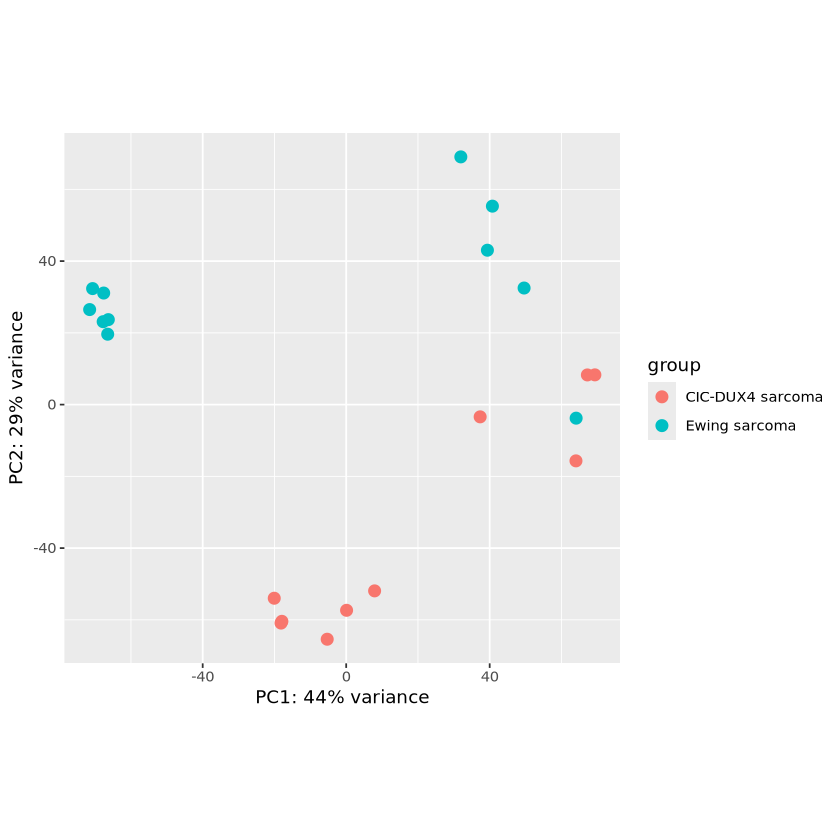

In [21]:
# I can of course also plot the uncorrected PCA by condition - note that I am using the top 500 features
vsd_topvar <- vsd[order(rowVars(assay(vsd)), decreasing=TRUE)[1:500], ]
plotPCA(vsd_topvar, intgroup="Condition")

using ntop=500 top features by variance



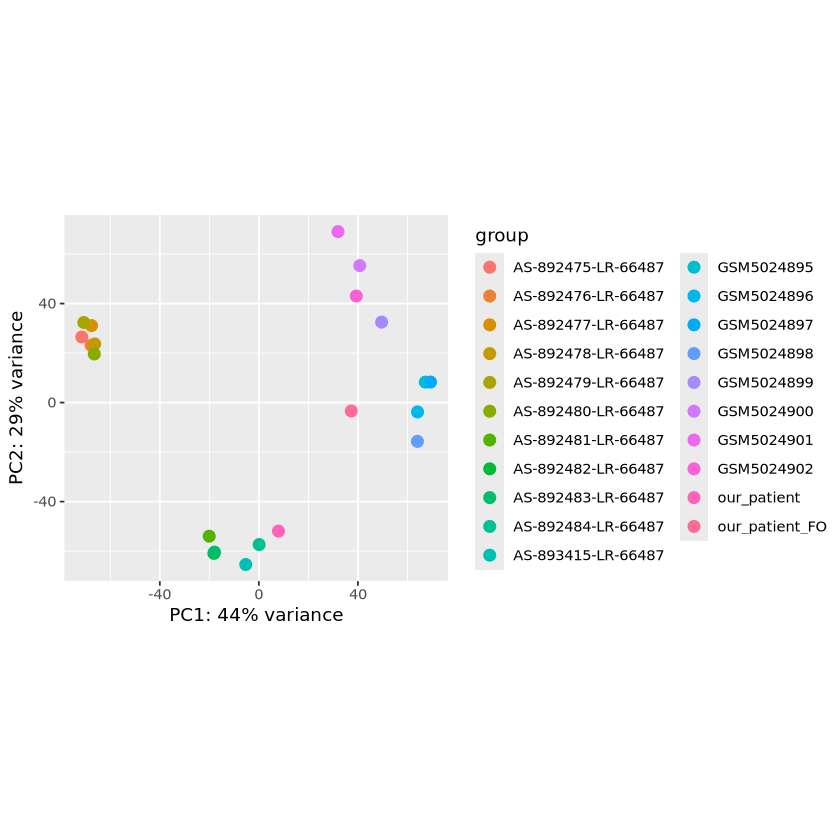

In [22]:
# and the uncorrected PCA by sample - note that I am using the top 500 features
d_topvar <- vsd[order(rowVars(assay(vsd)), decreasing=TRUE)[1:500], ]
plotPCA(vsd_topvar, intgroup="SampleID")

In [23]:
# here I am getting the rownames and filtering out all the LOC transcripts which are somewhat understudied
gene_names <- rownames(dds)
dds_filtered <- dds[gene_names, ]
dim(dds_filtered)
 # I am forming a results object whereby I will be contrasting the two groups by condition
res <- results(dds_filtered, contrast = c("Condition", "CIC-DUX4 sarcoma", "Ewing sarcoma"))
#group, target, reference is the syntax here

[1] 32479    21

In [24]:
# here I am extracting the differentially expressed genes from res
result <- as.data.frame(res)
# and removing na values
lg1 <- !is.na(result$log2FoldChange)
lg2 <- !is.na(result$padj)

result <- result[lg1&lg2,]
# filter by padj and log fold change (absolute)
lg3 <- result$padj < 0.05
lg4 <- abs(result$log2FoldChange) > 0
# get result
result <- result[lg3&lg4,]
# rder results according to padj
ord <- order(result$padj, decreasing = FALSE)
result <- result[ord,]
# view result
result[1:3,]
summary(result)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SYCP1,273.3043,-25.924309,1.609814,-16.10391,2.394675e-58,6.635646e-54
CALB2,1252.0593,13.539137,1.274571,10.62250,2.341986e-26,3.244822e-22
ADRB3,2494.3324,-9.603058,0.922843,-10.40595,2.329206e-25,2.151410e-21


    baseMean         log2FoldChange        lfcSE             stat         
 Min.   :     2.95   Min.   :-25.924   Min.   :0.1417   Min.   :-16.1039  
 1st Qu.:    59.46   1st Qu.: -2.312   1st Qu.:0.6281   1st Qu.: -3.2812  
 Median :   293.70   Median :  1.975   Median :0.8699   Median :  2.8846  
 Mean   :  1266.46   Mean   :  1.186   Mean   :0.8963   Mean   :  0.8045  
 3rd Qu.:  1025.57   3rd Qu.:  4.164   3rd Qu.:1.1215   3rd Qu.:  4.0739  
 Max.   :209354.02   Max.   : 25.309   Max.   :3.2039   Max.   : 10.6225  
     pvalue               padj          
 Min.   :0.000e+00   Min.   :0.000e+00  
 1st Qu.:2.217e-06   1st Qu.:5.687e-05  
 Median :2.601e-04   Median :3.336e-03  
 Mean   :1.416e-03   Mean   :1.093e-02  
 3rd Qu.:2.201e-03   3rd Qu.:1.882e-02  
 Max.   :7.783e-03   Max.   :4.994e-02  

In [25]:
# define conditions for upregulated, downregulated, and significant genes
test <- ifelse(result$padj < 0.01, TRUE, FALSE)
upregulated <- ifelse(test = result$log2FoldChange > 1, TRUE, FALSE)
downregulated <- ifelse(test = result$log2FoldChange < -1, TRUE, FALSE)

# define the state of each gene
state <- ifelse(test == TRUE & upregulated == TRUE, "Upregulated", 
                ifelse(test == TRUE & downregulated == TRUE, "Downregulated", "Not statistically significant"))

# get the genes to label - up or down
genes <- rownames(result)[test & (upregulated | downregulated)]

# prepare point labels
point_label <- rownames(result)
point_label[!(rownames(result) %in% genes)] <- ""

# define the target (cic-dux4) and reference (ewing)
target <- "CIC-DUX4_sarcoma"  
reference <- "Ewings_sarcoma" 

# create volcano plot
volcano_plot <- ggplot(data = result, mapping = aes(x = log2FoldChange, y = -log10(padj))) + 
  geom_point(mapping = aes(color = state, alpha = 0.9), size = 2) + 
  geom_text_repel(mapping = aes(label = point_label), max.overlaps = 10) +  
  guides(alpha = "none") +  # fixed guides issue
  labs(x = "log2 fold change", y = "-log10 adjusted p-value") +  # label
  ggtitle(paste0(target, " minus ", reference)) +  # title
  theme_minimal()
# save the plot
ggsave(filename = paste0("/lustre/scratch126/cellgen/behjati/lr26/RNA/", target, "_minus_", reference, "volcano_plot_swiss_italy.pdf"), 
       plot = volcano_plot, device = cairo_pdf, dpi = 300)

Saving 7 x 7 in image
Warning message:
“ggrepel: 2732 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [26]:
# here I am using the the org.Hs.eg.db package
# and mapping the entrez ids based on row names of the result df
result$entrez <- mapIds(org.Hs.eg.db, 
                        keys = rownames(result),   
                        column = "ENTREZID",       
                        keytype = "SYMBOL",       
                        multiVals = "first")       

# check the first few rows of the result to verify
head(result)



'select()' returned 1:1 mapping between keys and columns



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,entrez
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SYCP1,273.3043,-25.924309,1.6098142,-16.10391,2.394675e-58,6.635646e-54,6847
CALB2,1252.0593,13.539137,1.2745714,10.62250,2.341986e-26,3.244822e-22,794
ADRB3,2494.3324,-9.603058,0.9228430,-10.40595,2.329206e-25,2.151410e-21,155
CYP4F22,4307.7653,-10.205900,0.9893293,-10.31598,5.967005e-25,4.133643e-21,126410
PAX7,7885.6989,-11.027744,1.0818541,-10.19337,2.122669e-24,1.176383e-20,5081
TIE1,4418.0473,8.989134,0.8879388,10.12360,4.341635e-24,2.005112e-20,7075


In [27]:
# here I am doing a fast gene set enrichment analysis
# result dataframe with gene symbols, row names, entrez id, gene names

# I ensure that the 'entrez' column contains valid Entrez IDs for GSEA, remove those without ids
fgsea_data <- result[!is.na(result$entrez), ] 

# prepare the ranking - log2foldchange and check first few vals
#rank vector - entrez ids
ranks <- fgsea_data$log2FoldChange
names(ranks) <- fgsea_data$entrez  

# remove unknown vals
ranks <- ranks[!is.na(ranks)]

# msigdb hallmark pathways - load gene sets
pathways_df <- msigdbr(species = "Homo sapiens", category = "H")

# check the gene symbols are valid, each row a separate gene 
head(pathways_df)

# split pathways into a list, each element is a character vector of gene symbols
pathways_list <- split(pathways_df$entrez_gene, pathways_df$gs_name)

# run gsea for enriched pathway analysis
fgsea_res <- fgseaMultilevel(pathways_list, stats = ranks)
head(fgsea_res)
# sort by adjusted p-value (padj)
fgsea_res <- fgsea_res[order(fgsea_res$padj), ]

# view top 5 enriched pathways
head(fgsea_res)

# plot the results, setting normalised enrichment score to 0.5 above
fgsea_plot <- fgsea_res[abs(fgsea_res$NES) > 0.5, ]
fgsea_plot <- fgsea_plot[order(fgsea_plot$NES), ]

#  volcano plot and save it
library(ggplot2)
my_plot <- ggplot(fgsea_plot, aes(x = reorder(pathway, NES), y = NES)) +
  geom_col(aes(fill = padj > 0.05)) +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score (NES)", title = "FGSEA Enrichment: CIC-DUX4 vs Ewing Sarcoma") +
  theme_minimal() +
  theme(legend.position = "none")

ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/fgsea_volcano_plot_swiss_italy.pdf", my_plot, width = 10, height = 8, device = cairo_pdf, dpi = 300)


Warning message:
“The `category` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `collection` argument instead.”


,gene_symbol,ncbi_gene,ensembl_gene,db_gene_symbol,db_ncbi_gene,db_ensembl_gene,source_gene,gs_id,gs_name,gs_collection,⋯,gs_source_species,gs_pmid,gs_geoid,gs_exact_source,gs_url,db_version,db_target_species,entrez_gene,gs_cat,gs_subcat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ABCA1,19,ENSG00000165029,ABCA1,19,ENSG00000165029,ABCA1,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,19,H,
2,ABCB8,11194,ENSG00000197150,ABCB8,11194,ENSG00000197150,ABCB8,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,11194,H,
3,ACAA2,10449,ENSG00000167315,ACAA2,10449,ENSG00000167315,ACAA2,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,10449,H,
4,ACADL,33,ENSG00000115361,ACADL,33,ENSG00000115361,ACADL,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,33,H,
5,ACADM,34,ENSG00000117054,ACADM,34,ENSG00000117054,ACADM,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,34,H,
6,ACADS,35,ENSG00000122971,ACADS,35,ENSG00000122971,ACADS,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,35,H,


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.05% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_ADIPOGENESIS,1.297710e-01,3.346726e-01,0.13574094,0.3556399,1.3240671,31,"11343, 3...."
HALLMARK_ALLOGRAFT_REJECTION,4.313569e-07,1.056824e-05,0.67496286,0.5238613,2.3009724,66,"972, 945...."
HALLMARK_ANDROGEN_RESPONSE,7.762431e-01,9.436451e-01,0.04032954,0.2437074,0.7747884,17,"220, 563...."
HALLMARK_ANGIOGENESIS,9.940473e-04,6.088540e-03,0.45505987,0.6136695,1.9509626,17,"6696, 70...."
HALLMARK_APICAL_JUNCTION,3.512881e-02,1.434426e-01,0.26166352,0.3534608,1.5164039,58,"794, 129...."
HALLMARK_APICAL_SURFACE,9.169960e-01,9.436451e-01,0.08312913,-0.1614940,-0.6546829,20,"255738, ...."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_INFLAMMATORY_RESPONSE,1.780384e-07,8.723881e-06,0.6901325,0.5198061,2.293283,69,"5996, 18...."
HALLMARK_ALLOGRAFT_REJECTION,4.313569e-07,1.056824e-05,0.6749629,0.5238613,2.300972,66,"972, 945...."
HALLMARK_KRAS_SIGNALING_UP,3.853664e-06,6.294318e-05,0.6105269,0.4745851,2.122911,74,"6696, 56...."
HALLMARK_COAGULATION,1.127774e-04,1.381523e-03,0.5384341,0.5298869,2.058738,37,"712, 705...."
HALLMARK_COMPLEMENT,1.864833e-04,1.760177e-03,0.5188481,0.4542197,1.973202,61,"712, 714...."
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,2.514538e-04,1.760177e-03,0.4984931,0.4210651,1.883506,74,"6696, 70...."


In [28]:
# normalized counts from dds object
norm_counts <- counts(dds, normalized=TRUE)

# specific genes of interest 
genes_of_interest <- c("CIC", "DUX4", "EWSR1", "MYOD1")

# subset normalised counts for the genes 
expression_data <- norm_counts[genes_of_interest, ]
print(expression_data)


      AS-892475-LR-66487 AS-892476-LR-66487 AS-892477-LR-66487
CIC              3704.71       4.880930e+03           10536.35
DUX4                0.00       7.626454e-01               0.00
EWSR1           14468.88       1.272169e+04           11120.08
MYOD1               0.00       9.914390e+00               0.00
      AS-892478-LR-66487 AS-892479-LR-66487 AS-892480-LR-66487
CIC             7908.605           6041.075        3190.667238
DUX4               0.000              0.000           0.000000
EWSR1          11443.871          10507.280       21216.495462
MYOD1              0.000              0.000           5.626039
      AS-892481-LR-66487 AS-892482-LR-66487 AS-892483-LR-66487
CIC           10961.1577         3757.61741         11829.2935
DUX4            192.1261           54.96515           126.1611
EWSR1         19009.8438        13830.60542         14212.2741
MYOD1             0.0000            0.00000             0.0000
      AS-892484-LR-66487 AS-893415-LR-66487  GSM5024895

In [29]:
# data frame with normalized counts and sample information
expression_df <- as.data.frame(t(expression_data))  # get samples in rows
expression_df$Condition <- colData(dds)$Condition  # add condition information

# view the data frame to check it
head(expression_df)


,CIC,DUX4,EWSR1,MYOD1,Condition
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
AS-892475-LR-66487,3704.710,0.0000000,14468.88,0.000000,Ewing sarcoma
AS-892476-LR-66487,4880.930,0.7626454,12721.69,9.914390,Ewing sarcoma
AS-892477-LR-66487,10536.345,0.0000000,11120.08,0.000000,Ewing sarcoma
AS-892478-LR-66487,7908.605,0.0000000,11443.87,0.000000,Ewing sarcoma
AS-892479-LR-66487,6041.075,0.0000000,10507.28,0.000000,Ewing sarcoma
AS-892480-LR-66487,3190.667,0.0000000,21216.50,5.626039,Ewing sarcoma


In [ ]:
# reshape into long format
expression_long_df <- gather(expression_df, key = "Gene", value = "Expression", -Condition)

# plot per condition
p <- ggplot(expression_long_df, aes(x=Condition, y=Expression, fill=Condition)) + 
  geom_boxplot() + 
  facet_wrap(~Gene, scales="free_y") +
  labs(title="Expression of Genes across Conditions", x="Condition", y="Normalized Expression") +
  theme_minimal()

# save the plot
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/Expression_of_Genes_across_Conditions_swiss_italy.pdf", 
       plot = p, device = cairo_pdf, dpi = 300, width = 10, height = 8)

In [41]:
# comparing our patient to all others
# here, I re-run for both the FT and FO samples
vst_data <- vst(dds, blind = TRUE)
vst_mat <- assay(vst_data)
uk_sample <- vst_mat[, "our_patient_FO"]

# matrix without FO sample
others <- vst_mat[, colnames(vst_mat) != "our_patient_FO"]
# calculate z-score of the FO sample expression vs. others
uk_z <- (uk_sample - rowMeans(others)) / apply(others, 1, sd)
# sort by magnitude of z-score
top_var_genes <- head(sort(abs(uk_z), decreasing = TRUE), 50)
# view gene names
names(top_var_genes)

# plot
top_df <- data.frame(
  gene = names(top_var_genes),
  zscore = uk_z[names(top_var_genes)]
)
our_patient <- ggplot(top_df, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Top Variable Genes in FO sample vs. Other",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal()
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_FO_plot_swissitaly.pdf", our_patient, width = 8, height = 10, device = cairo_pdf, dpi = 300)

### can rerun for the FT sample

[1] "LINC00312"     "LOC124900464"  "LOC124900530"  "LOC124905413" 
 [5] "LOC124906156"  "HSD17B3"       "LOC644634"     "SNORA88"      
 [9] "LOC124908181"  "LOC124903267"  "LOC124904827"  "SULT1A4"      
[13] "LOC124900907"  "LOC124907510"  "IFNE"          "NPIPA6"       
[17] "LOC124902275"  "FGF12-AS3"     "LOC124903424"  "SNORD13I"     
[21] "LOC124900898"  "LOC107985201"  "LOC105371975"  "LOC124900188" 
[25] "FAM133B"       "LOC105371472"  "PSORS1C1"      "LOC100506274" 
[29] "SMIM10L2B-AS1" "BPIFB4"        "EGFL8"         "VIP"          
[33] "LOC124907554"  "LOC128966590"  "LOC105376090"  "NPFF"         
[37] "C19orf18"      "ATXN7L3-AS1"   "LOC107984201"  "TILAM"        
[41] "LOC124901201"  "LOC128966699"  "ACTN1-DT"      "C5orf58"      
[45] "RASGRF2-AS1"   "DCANP1"        "SPOCD1"        "LOC124903604" 
[49] "LOC124901209"  "LOC124906338"

In [ ]:
# comparing our patient to all others
# here, I re-run for both the FT and FO samples
# I conveniently named the FO sample our_patient_FO and the FT sample our_patient
vst_data <- vst(dds, blind = TRUE)
vst_mat <- assay(vst_data)
uk_sample <- vst_mat[, "our_patient"]

# matrix without FO sample
others <- vst_mat[, colnames(vst_mat) != "our_patient"]
# calculate z-score of the FO sample expression vs. others
uk_z <- (uk_sample - rowMeans(others)) / apply(others, 1, sd)
# sort by magnitude of z-score
top_var_genes <- head(sort(abs(uk_z), decreasing = TRUE), 50)
# view gene names
names(top_var_genes)

# plot
top_df <- data.frame(
  gene = names(top_var_genes),
  zscore = uk_z[names(top_var_genes)]
)
our_patient <- ggplot(top_df, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Top Variable Genes in FT sample vs. Other",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal()
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_FT_plot_swissitaly.pdf", our_patient, width = 8, height = 10, device = cairo_pdf, dpi = 300)


In [39]:
#comparing our patient to all others
vst_data <- vst(dds, blind = TRUE)
vst_mat <- assay(vst_data)
# combine the two samples into one matrix
uk_sample <- vst_mat[, c("our_patient_FO", "our_patient")]
# get all other samples excluding those two
others <- vst_mat[, !colnames(vst_mat) %in% c("our_patient_FO", "our_patient")]

# average UK sample expression
uk_avg <- rowMeans(uk_sample)
# z-score against other samples
uk_z <- (uk_avg - rowMeans(others)) / apply(others, 1, sd)
# sort and get top 50 genes
top_var_genes <- head(sort(abs(uk_z), decreasing = TRUE), 50)

# create data frame
top_df <- data.frame(
  gene = names(top_var_genes),
  zscore = uk_z[names(top_var_genes)]
)
# save plot
our_patient <- ggplot(top_df, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Top Variable Genes in UK Sample vs. Other",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal()
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_FO_FT_plot_swissitaly.pdf", our_patient, width = 8, height = 10, device = cairo_pdf, dpi = 300)


In [12]:
####
# ANALYSIS without the 900 sample outlier #

# subset metadata to exclude sample
sample_to_exclude <- "GSM5024900"

# remove column from count matrix
counts_filtered <- counts_rounded[, colnames(counts_rounded) != sample_to_exclude]
colnames(counts_filtered)
# remove row from metadata — match the sample name
metadata_filtered <- metadata[metadata$SampleID != "GSM5024900", ]

# set rownames of metadata to match the colnames of count matrix
rownames(metadata_filtered) <- paste0(metadata_filtered$SampleID)
rownames(metadata_filtered)
# check if they match
# create a new de seq data set
ddds <- DESeqDataSetFromMatrix(countData = counts_filtered,
                              colData = metadata_filtered,
                              design = ~ Study + Condition)
ddds <- DESeq(ddds)


[1] "AS-892475-LR-66487" "AS-892476-LR-66487" "AS-892477-LR-66487"
 [4] "AS-892478-LR-66487" "AS-892479-LR-66487" "AS-892480-LR-66487"
 [7] "AS-892481-LR-66487" "AS-892482-LR-66487" "AS-892483-LR-66487"
[10] "AS-892484-LR-66487" "AS-893415-LR-66487" "GSM5024895"        
[13] "GSM5024896"         "GSM5024897"         "GSM5024898"        
[16] "GSM5024899"         "GSM5024901"         "GSM5024902"        
[19] "our_patient_FO"     "our_patient"

[1] "AS-892475-LR-66487" "AS-892476-LR-66487" "AS-892477-LR-66487"
 [4] "AS-892478-LR-66487" "AS-892479-LR-66487" "AS-892480-LR-66487"
 [7] "AS-892481-LR-66487" "AS-892482-LR-66487" "AS-892483-LR-66487"
[10] "AS-892484-LR-66487" "AS-893415-LR-66487" "GSM5024895"        
[13] "GSM5024896"         "GSM5024897"         "GSM5024898"        
[16] "GSM5024899"         "GSM5024901"         "GSM5024902"        
[19] "our_patient_FO"     "our_patient"

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is reco

In [13]:
# correct for variance and perform pca, plot it
vsd_1 <- vst(ddds, blind = FALSE)
corrected <- limma::removeBatchEffect(assay(vsd_1), batch = vsd_1$Study)
pca_res <- prcomp(t(corrected)) 

pca_df <- as.data.frame(pca_res$x)
pca_df$Condition <- vsd_1$Condition
pca_df$Sample <- colnames(vsd_1)

# by condition
m <- ggplot(pca_df, aes(x = PC1, y = PC2, color = Condition, label = Sample)) +
  geom_point(size = 3) +
  labs(title = "PCA (Batch-corrected with limma)", x = "PC1", y = "PC2") +
  theme_minimal()
ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/pca_batch_corrected_by_cond_wo900_swiss_italy.pdf", plot = m, width = 8, height = 6, dpi = 300, device = cairo_pdf)

In [14]:
# by sample name
m <- ggplot(pca_df, aes(x = PC1, y = PC2, color = Sample, label = Sample)) +
  geom_point(size = 3) +
  labs(title = "PCA (Batch-corrected with limma)", x = "PC1", y = "PC2") +
  theme_minimal()

ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/pca_batch_corrected_by_sample_wo900_swiss_italy.pdf", plot = m, width = 8, height = 6, dpi = 300, device = cairo_pdf)

In [15]:
# obtain the gene expression matrix
exprs.data=assay(vsd_1)
# inspect exprs.data
exprs.data[1:3,1:3]


,AS-892475-LR-66487,AS-892476-LR-66487,AS-892477-LR-66487
A1BG,8.687837,7.560719,8.487211
A1BG-AS1,7.595658,8.083726,8.631218
A1CF,3.909543,3.909543,3.909543


In [59]:
# plot pca using top 500 features
vsd1_topvar <- vsd_1[order(rowVars(assay(vsd_1)), decreasing=TRUE)[1:500], ]
m <- plotPCA(vsd1_topvar, intgroup="Condition")
ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/pca_plot_RNA_900_CIC-EWS-condition.pdf", plot = m, width = 6, height = 5)

using ntop=500 top features by variance



In [58]:
# plot pca using top 500 features
vsd1_topvar <- vsd_1[order(rowVars(assay(vsd_1)), decreasing=TRUE)[1:500], ]
p <- plotPCA(vsd1_topvar, intgroup="SampleID")
ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/pca_plot_RNA_900_CIC-EWS-sampleid.pdf", plot = p, width = 6, height = 5)

using ntop=500 top features by variance



In [16]:
# prcomp diagnostic plots - summary and plot the pca
pca_prcomp = prcomp(t(exprs.data), scale=FALSE)

summary(pca_prcomp$x)
summary(pca_prcomp$rotation)
summary(pca_prcomp$sdev)

pdf("/lustre/scratch126/cellgen/behjati/lr26/RNA/PCA-900-swiss-italy.pdf")
par(mfrow=c(2,2))
plot(pca_prcomp$x[,1:2], main='Sample plot', col=colData(vsd_1)$sample, pch=19)
text(pca_prcomp$x[,1:2], labels=rownames(pca_prcomp$x[,1:2]), pos=4, cex=0.8)
abline(v=0, h=0, col=8)

plot( pca_prcomp$rotation[,1:2], main='Gene loading')
abline(v=0, h=0, col=8)

eig = (pca_prcomp$sdev)^2; names(eig) = 1:length(eig); eig= 100* eig/sum(eig)
barplot(eig, main='Scree plot', xlab= "PC", ylab = 'Percentage of explained variances')
dev.off()

      PC1               PC2               PC3                PC4         
 Min.   :-168.19   Min.   :-139.53   Min.   :-140.692   Min.   :-84.141  
 1st Qu.:-148.01   1st Qu.: -94.41   1st Qu.: -35.226   1st Qu.:-28.764  
 Median : -82.58   Median :  11.48   Median :   0.243   Median :  1.522  
 Mean   :   0.00   Mean   :   0.00   Mean   :   0.000   Mean   :  0.000  
 3rd Qu.: 161.10   3rd Qu.:  91.02   3rd Qu.:  37.216   3rd Qu.: 20.116  
 Max.   : 324.57   Max.   : 138.88   Max.   : 123.104   Max.   :159.697  
      PC5               PC6               PC7               PC8         
 Min.   :-79.581   Min.   :-77.814   Min.   :-59.338   Min.   :-65.786  
 1st Qu.:-26.735   1st Qu.:-32.011   1st Qu.:-30.097   1st Qu.:-15.821  
 Median : -2.341   Median : -4.716   Median : -1.672   Median : -7.257  
 Mean   :  0.000   Mean   :  0.000   Mean   :  0.000   Mean   :  0.000  
 3rd Qu.: 37.527   3rd Qu.: 36.539   3rd Qu.: 30.736   3rd Qu.:  9.572  
 Max.   :115.432   Max.   : 67.099   Max.   

      PC1                  PC2                  PC3            
 Min.   :-0.0156976   Min.   :-0.0544306   Min.   :-0.0378765  
 1st Qu.:-0.0004861   1st Qu.:-0.0013366   1st Qu.:-0.0018168  
 Median : 0.0021312   Median : 0.0004784   Median : 0.0013630  
 Mean   : 0.0024253   Mean   : 0.0001218   Mean   : 0.0006774  
 3rd Qu.: 0.0048900   3rd Qu.: 0.0023373   3rd Qu.: 0.0039943  
 Max.   : 0.0352809   Max.   : 0.0509277   Max.   : 0.0322065  
      PC4                  PC5                 PC6            
 Min.   :-5.281e-02   Min.   :-0.052820   Min.   :-0.0384097  
 1st Qu.:-3.366e-03   1st Qu.:-0.003769   1st Qu.:-0.0030954  
 Median :-9.036e-05   Median :-0.001235   Median :-0.0007696  
 Mean   :-4.573e-04   Mean   :-0.001365   Mean   :-0.0004253  
 3rd Qu.: 2.607e-03   3rd Qu.: 0.001601   3rd Qu.: 0.0021299  
 Max.   : 3.097e-02   Max.   : 0.036511   Max.   : 0.0426576  
      PC7                  PC8                  PC9            
 Min.   :-5.212e-02   Min.   :-0.0507493   Min.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   26.75   31.81   42.39   42.97  166.64 

pdf 
  2

In [17]:
# get expression data and assign sample colors for the correlation heatmap
exprs.data <- assay(vsd_1)
cor.data <- cor(exprs.data, method = 'pearson')

col.group <- rainbow(length(unique(colData(vsd_1)$SampleID)))[as.factor(colData(vsd_1)$SampleID)]

# save the plot
pdf('/lustre/scratch126/cellgen/behjati/lr26/RNA/correlation-900-swiss-italy.pdf', width = 10, height = 10)

heatmap.2(as.matrix(cor.data),
          col = colorRampPalette(brewer.pal(10, "RdYlBu"))(256),
          trace = "none",
          srtCol = 45,
          margins = c(12, 18),        # Wider left margin for Y labels
          cexCol = 1.2,               # Font size for column labels
          cexRow = 1.2,               # Font size for row labels (Y-axis)
          density.info = "none",
          lhei = c(2, 10),
          keysize = 1.0,
          main = "Sample Correlations -900",
          scale = "none",
          ColSideColors = col.group,
          RowSideColors = col.group)

dev.off()

pdf 
  2

In [18]:
# get row names of the ddds
gene_names <- rownames(ddds)

# subset for those without LOC
ddds_filtered <- ddds[gene_names, ]

# check and compare groups
dim(ddds_filtered)

res_1 <- results(ddds_filtered, contrast = c("Condition", "CIC-DUX4 sarcoma", "Ewing sarcoma"))
#group, target, reference

[1] 32479    20

In [19]:
# extract degs from res
result_1 <- as.data.frame(res_1)
# remove missing values
lg1 <- !is.na(result_1$log2FoldChange)
lg2 <- !is.na(result_1$padj)
result_1 <- result_1[lg1&lg2,] 

#filter by padj and log fold change 
lg3 <- result_1$padj < 0.05
lg4 <- abs(result_1$log2FoldChange) > 0
result_1 <- result_1[lg3&lg4,]

# order results according to padj
ord <- order(result_1$padj, decreasing = FALSE)
result_1 <- result_1[ord,]
# view
result_1[1:3,]
summary(result_1)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SYCP1,323.8125,-25.923965,1.6971827,-15.27470,1.127375e-52,3.155747e-48
CYP4F22,5216.0990,-10.805509,0.9391321,-11.50585,1.232754e-30,1.725362e-26
ADRB3,3017.9877,-9.942332,0.9047894,-10.98856,4.337900e-28,3.035662e-24


    baseMean         log2FoldChange        lfcSE             stat        
 Min.   :     3.15   Min.   :-25.924   Min.   :0.1159   Min.   :-15.275  
 1st Qu.:    71.14   1st Qu.: -1.750   1st Qu.:0.5027   1st Qu.: -3.127  
 Median :   374.81   Median :  1.751   Median :0.7812   Median :  2.899  
 Mean   :  1606.65   Mean   :  1.190   Mean   :0.8220   Mean   :  1.004  
 3rd Qu.:  1394.97   3rd Qu.:  3.669   3rd Qu.:1.0705   3rd Qu.:  3.976  
 Max.   :282054.78   Max.   : 27.119   Max.   :3.1789   Max.   : 10.588  
     pvalue               padj          
 Min.   :0.000e+00   Min.   :0.000e+00  
 1st Qu.:3.382e-06   1st Qu.:7.013e-05  
 Median :3.354e-04   Median :3.480e-03  
 Mean   :1.798e-03   Mean   :1.124e-02  
 3rd Qu.:2.771e-03   3rd Qu.:1.917e-02  
 Max.   :9.634e-03   Max.   :4.999e-02  

In [20]:
# define conditions for upregulated, downregulated, and significant genes
test <- ifelse(result_1$padj < 0.01, TRUE, FALSE)
upregulated <- ifelse(test = result_1$log2FoldChange > 1, TRUE, FALSE)
downregulated <- ifelse(test = result_1$log2FoldChange < -1, TRUE, FALSE)

# define the state of each gene
state <- ifelse(test == TRUE & upregulated == TRUE, "Upregulated", 
                ifelse(test == TRUE & downregulated == TRUE, "Downregulated", "Not statistically significant"))

# get the genes to label
genes <- rownames(result_1)[test & (upregulated | downregulated)]

# prepare point labels
point_label <- rownames(result_1)
point_label[!(rownames(result_1) %in% genes)] <- ""

# define the target and reference variables
target <- "CIC-DUX4_sarcoma" #
reference <- "Ewings_sarcoma" 

# volcano plot and save it
volcano_plot <- ggplot(data = result_1, mapping = aes(x = log2FoldChange, y = -log10(padj))) + 
  geom_point(mapping = aes(color = state, alpha = 0.9), size = 2) + 
  geom_text_repel(mapping = aes(label = point_label), max.overlaps = 10) +  
  guides(alpha = "none") +  
  labs(x = "log2 fold change", y = "-log10 adjusted p-value") + 
  ggtitle(paste0(target, " minus ", reference, "-900")) +  
  theme_minimal()
ggsave(filename = paste0("/lustre/scratch126/cellgen/behjati/lr26/RNA/", target, "_minus_", reference, "volcano_plot-900swissitaly.pdf"), 
       plot = volcano_plot, device = cairo_pdf, dpi = 300)

Saving 7 x 7 in image
Warning message:
“ggrepel: 3272 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [21]:
# gene set enrichment formatting
result_1$entrez <- mapIds(org.Hs.eg.db, 
                        keys = rownames(result_1),   
                        column = "ENTREZID",    
                        keytype = "SYMBOL",      
                        multiVals = "first")     

# check the first few rows of the result to verify
head(result_1)



'select()' returned 1:1 mapping between keys and columns



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,entrez
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SYCP1,323.8125,-25.923965,1.6971827,-15.27470,1.127375e-52,3.155747e-48,6847
CYP4F22,5216.0990,-10.805509,0.9391321,-11.50585,1.232754e-30,1.725362e-26,126410
ADRB3,3017.9877,-9.942332,0.9047894,-10.98856,4.337900e-28,3.035662e-24,155
PKP1,16535.7536,-10.745756,0.9773841,-10.99441,4.065854e-28,3.035662e-24,5317
UGT3A2,17985.8092,-12.253102,1.1245236,-10.89626,1.200919e-27,6.723224e-24,167127
PAX7,9610.0401,-11.574930,1.0854512,-10.66370,1.504826e-26,7.020514e-23,5081


In [22]:
# pathway enrichment analysis just like above
# ensure that entrez column contains valid entrez ids
fgsea_data <- result_1[!is.na(result_1$entrez), ]  

# prepare ranking (log2FoldChange)
# first few values, numeric
ranks <- fgsea_data$log2FoldChange
names(ranks) <- fgsea_data$entrez

# Remove any nan values
ranks <- ranks[!is.na(ranks)]

# hallmark gene set pathways
pathways_df <- msigdbr(species = "Homo sapiens", category = "H")

# valid gene symbols, each row a separate gene
head(pathways_df)
# split pathways into a list, each element a char vector of gene symbols
pathways_list <- split(pathways_df$entrez_gene, pathways_df$gs_name)

# fun fgsea
fgsea_res <- fgseaMultilevel(pathways_list, stats = ranks)
head(fgsea_res)
# sort the results by padj
fgsea_res <- fgsea_res[order(fgsea_res$padj), ]
# top 5 enriched pathways
head(fgsea_res)

# plot the results for pathways 
fgsea_plot <- fgsea_res[abs(fgsea_res$NES) > 0.5, ]
fgsea_plot <- fgsea_plot[order(fgsea_plot$NES), ]

# volcano plot for pathway enrichment and save the plot
library(ggplot2)
my_plot <- ggplot(fgsea_plot, aes(x = reorder(pathway, NES), y = NES)) +
  geom_col(aes(fill = padj > 0.05)) +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score (NES)", title = "FGSEA Enrichment: CIC-DUX4 vs Ewing Sarcoma-900") +
  theme_minimal() +
  theme(legend.position = "none")
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/fgsea_volcano_plot-900-swissitaly.pdf", my_plot, width = 10, height = 8, device = cairo_pdf, dpi = 300)


Warning message:
“The `category` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `collection` argument instead.”


,gene_symbol,ncbi_gene,ensembl_gene,db_gene_symbol,db_ncbi_gene,db_ensembl_gene,source_gene,gs_id,gs_name,gs_collection,⋯,gs_source_species,gs_pmid,gs_geoid,gs_exact_source,gs_url,db_version,db_target_species,entrez_gene,gs_cat,gs_subcat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ABCA1,19,ENSG00000165029,ABCA1,19,ENSG00000165029,ABCA1,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,19,H,
2,ABCB8,11194,ENSG00000197150,ABCB8,11194,ENSG00000197150,ABCB8,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,11194,H,
3,ACAA2,10449,ENSG00000167315,ACAA2,10449,ENSG00000167315,ACAA2,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,10449,H,
4,ACADL,33,ENSG00000115361,ACADL,33,ENSG00000115361,ACADL,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,33,H,
5,ACADM,34,ENSG00000117054,ACADM,34,ENSG00000117054,ACADM,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,34,H,
6,ACADS,35,ENSG00000122971,ACADS,35,ENSG00000122971,ACADS,M5905,HALLMARK_ADIPOGENESIS,H,⋯,HS,26771021,,,,2024.1.Hs,HS,35,H,


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_ADIPOGENESIS,1.804697e-01,4.496714e-01,0.11056472,0.3306458,1.2387489,42,"11343, 3...."
HALLMARK_ALLOGRAFT_REJECTION,7.654925e-07,2.366065e-05,0.65944440,0.5105688,2.1513500,80,"972, 468...."
HALLMARK_ANDROGEN_RESPONSE,9.576720e-01,9.910486e-01,0.02822192,0.1666169,0.5533633,25,"220, 563...."
HALLMARK_ANGIOGENESIS,3.077802e-03,1.919860e-02,0.43170770,0.5748098,1.7883121,20,"6696, 70...."
HALLMARK_APICAL_JUNCTION,1.372140e-02,6.236999e-02,0.38073040,0.3772664,1.5398961,67,"794, 129...."
HALLMARK_APICAL_SURFACE,9.072581e-01,9.910486e-01,0.08479851,-0.1745998,-0.7016420,24,"5314, 25...."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_ALLOGRAFT_REJECTION,7.654925e-07,2.366065e-05,0.6594444,0.5105688,2.151350,80,"972, 468...."
HALLMARK_INFLAMMATORY_RESPONSE,9.464260e-07,2.366065e-05,0.6594444,0.5154829,2.155710,76,"5996, 18...."
HALLMARK_KRAS_SIGNALING_UP,6.373456e-06,1.062243e-04,0.6105269,0.4838706,2.040475,81,"6696, 56...."
HALLMARK_IL6_JAK_STAT3_SIGNALING,3.993195e-05,4.991494e-04,0.5573322,0.5574122,2.088318,42,"8809, 12...."
HALLMARK_COAGULATION,1.270860e-04,1.059050e-03,0.5188481,0.5248191,1.993365,44,"712, 705...."
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1.156322e-04,1.059050e-03,0.5384341,0.4513346,1.901759,80,"6696, 70...."


In [23]:
# here again targeted analysis for the genes of interest
norm_counts <- counts(ddds, normalized=TRUE)
genes_of_interest <- c("CIC", "DUX4", "EWSR1", "MYOD1")

# subset the normalized counts for these genes
expression_data <- norm_counts[genes_of_interest, ]
print(expression_data)
# create a gataframe and transpose and add condition info
expression_df <- as.data.frame(t(expression_data))  
expression_df$Condition <- colData(ddds)$Condition 

# view and put to long format
head(expression_df)
expression_long_df <- gather(expression_df, key = "Gene", value = "Expression", -Condition)

# get deseq2 results
res <- results(ddds)
# p values for genes of interest
gene_pvals <- res[genes_of_interest, c("padj", "pvalue")]

# convert to dataframe
gene_pvals_df <- as.data.frame(gene_pvals)
gene_pvals_df$Gene <- rownames(gene_pvals_df)

gene_pvals_df$label <- ifelse(
  is.na(gene_pvals_df$padj),
  paste0("p=", signif(gene_pvals_df$pvalue, 3)),
  paste0("FDR=", signif(gene_pvals_df$padj, 3))
)

# create the plot
p <- ggplot(expression_long_df, aes(x=Condition, y=Expression, fill=Condition)) + 
  geom_boxplot() + 
  facet_wrap(~Gene, scales="free_y") + 
  labs(title="Expression of Genes across Conditions -900", x="Condition", y="Normalized Expression") +
  theme_minimal() +
  geom_text(
    data = gene_pvals_df, 
    aes(x = 1.5, y = Inf, label = label), 
    inherit.aes = FALSE,
    vjust = 1.5, size = 3
  )
# save the plot
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/Expression_of_Genes_across_Conditions-900swissitaly.pdf", 
       plot = p, device = cairo_pdf, dpi = 300, width = 10, height = 8)

      AS-892475-LR-66487 AS-892476-LR-66487 AS-892477-LR-66487
CIC             4207.188       5.533109e+03           12105.57
DUX4               0.000       8.645483e-01               0.00
EWSR1          16431.322       1.442153e+04           12776.25
MYOD1              0.000       1.123913e+01               0.00
      AS-892478-LR-66487 AS-892479-LR-66487 AS-892480-LR-66487
CIC             8972.308           6867.152        3598.213510
DUX4               0.000              0.000           0.000000
EWSR1          12983.066          11944.080       23926.494022
MYOD1              0.000              0.000           6.344657
      AS-892481-LR-66487 AS-892482-LR-66487 AS-892483-LR-66487
CIC            12438.341         4290.17567         13612.7701
DUX4             218.018           62.75523           145.1821
EWSR1          21571.711        15790.78454         16355.0274
MYOD1              0.000            0.00000             0.0000
      AS-892484-LR-66487 AS-893415-LR-66487 GSM5024895 

,CIC,DUX4,EWSR1,MYOD1,Condition
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
AS-892475-LR-66487,4207.188,0.0000000,16431.32,0.000000,Ewing sarcoma
AS-892476-LR-66487,5533.109,0.8645483,14421.53,11.239128,Ewing sarcoma
AS-892477-LR-66487,12105.573,0.0000000,12776.25,0.000000,Ewing sarcoma
AS-892478-LR-66487,8972.308,0.0000000,12983.07,0.000000,Ewing sarcoma
AS-892479-LR-66487,6867.152,0.0000000,11944.08,0.000000,Ewing sarcoma
AS-892480-LR-66487,3598.214,0.0000000,23926.49,6.344657,Ewing sarcoma


ERROR: Error in gather(expression_df, key = "Gene", value = "Expression", -Condition): could not find function "gather"


In [ ]:
### deg for the FO sample
vst_data <- vst(ddds, blind = TRUE)
vst_mat <- assay(vst_data)
uk_sample_fo <- vst_mat[, "our_patient_FO"]

# get matrix without the FO sample
others <- vst_mat[, colnames(vst_mat) != "our_patient_FO"]

# calculate z score of the FO sample expression vs others
gene_sd <- apply(others, 1, sd)
uk_z_fo <- (uk_sample_fo - rowMeans(others)) / gene_sd
uk_z_fo <- uk_z_fo[!is.na(uk_z_fo) & gene_sd != 0]

# calculate two sided p values from z scores
p_values_fo <- 2 * pnorm(-abs(uk_z_fo))
names(p_values_fo) <- names(uk_z_fo)

# adjust for multiple testing
p_adj_fo <- p.adjust(p_values_fo, method = "BH")
names(p_adj_fo) <- names(p_values_fo)

# sort by magnitude of z score
top_var_genes_fo <- head(sort(abs(uk_z_fo), decreasing = TRUE), 50)

# view gene names
top_df_fo <- data.frame(
  gene = names(top_var_genes_fo),
  zscore = uk_z_fo[names(top_var_genes_fo)], 
  p_adj = p_adj_fo[names(top_var_genes_fo)]
)

top_df_fo$p_adj_label <- signif(top_df_fo$p_adj, digits = 2)

# plot the data - top differentially expressed
our_patient_fo <- ggplot(top_df_fo, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = p_adj_label), 
            hjust = -0.1,
            size = 3) +
  coord_flip() +
  labs(title = "Top Variable Genes in Our patient pre-treatment vs others",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal()

ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_foplot-900-swissitaly.pdf",
       our_patient_fo,
       width = 8, height = 10, device = cairo_pdf, dpi = 300)


In [ ]:
## deg for the ft sample
vst_data <- vst(ddds, blind = TRUE)
vst_mat <- assay(vst_data)
uk_sample_ft <- vst_mat[, "our_patient"]

# get matrix without the FO sample
others <- vst_mat[, colnames(vst_mat) != "our_patient"]

# calculate z score of the FO sample expression vs others
gene_sd <- apply(others, 1, sd)
uk_z_ft <- (uk_sample_ft - rowMeans(others)) / gene_sd
uk_z_ft <- uk_z_ft[!is.na(uk_z_ft) & gene_sd != 0]

# calculate two sided p values from z scores
p_values_ft <- 2 * pnorm(-abs(uk_z_ft))
names(p_values_ft) <- names(uk_z_ft)

# adjust for multiple testing
p_adj_ft <- p.adjust(p_values_ft, method = "BH")
names(p_adj_ft) <- names(p_values_ft)

# sort by magnitude of z score
top_var_genes_ft <- head(sort(abs(uk_z_ft), decreasing = TRUE), 50)

# view gene names
top_df_ft <- data.frame(
  gene = names(top_var_genes_ft),
  zscore = uk_z_ft[names(top_var_genes_ft)], 
  p_adj = p_adj_ft[names(top_var_genes_ft)]
)

top_df_ft$p_adj_label <- signif(top_df_ft$p_adj, digits = 2)

# plot the data - top differentially expressed
our_patient_ft <- ggplot(top_df_ft, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = p_adj_label), 
            hjust = -0.1,
            size = 3) +
  coord_flip() +
  labs(title = "Top Variable Genes in Our patient post-treatment vs others",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal()

ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_ftplot-900-swissitaly.pdf",
       our_patient_ft,
       width = 8, height = 10, device = cairo_pdf, dpi = 300)


In [148]:
#comparing our patient to all others
vst_data <- vst(ddds, blind = TRUE)
vst_mat <- assay(vst_data)

# combine the two samples into one matrix
uk_sample <- vst_mat[, c("our_patient_FO", "our_patient")]

# get all other samples excluding those two
others <- vst_mat[, !colnames(vst_mat) %in% c("our_patient_FO", "our_patient")]

# average UK sample expression
uk_avg <- rowMeans(uk_sample)

# z score against other samples
uk_z <- (uk_avg - rowMeans(others)) / apply(others, 1, sd)

# sort and get top 50 genes
top_var_genes <- head(sort(abs(uk_z), decreasing = TRUE), 50)

p_values <- 2 * pnorm(-abs(uk_z))
# assign names before adjustment
names(p_values) <- names(uk_z)
# adjust for multiple testing
p_adj <- p.adjust(p_values, method = "BH")
names(p_adj) <- names(p_values)  # just to be safe
# sort by magnitude of z score
top_var_genes <- head(sort(abs(uk_z), decreasing = TRUE), 50)

# view gene names
names(top_var_genes)
top_df <- data.frame(
  gene = names(top_var_genes),
  zscore = uk_z[names(top_var_genes)], 
  p_adj = p_adj[names(top_var_genes)]
)

top_df$p_adj_label <- signif(top_df$p_adj, digits = 2)
# graph
our_patient <- ggplot(top_df, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = p_adj_label), 
            hjust = -0.1,    # position labels just outside bars
            size = 3) +
  coord_flip() +
  labs(title = "Top Variable Genes in Our patient vs. Others",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal()
ggsave(filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_900_FO_FT_plot_swissitaly.pdf", our_patient, width = 8, height = 10, device = cairo_pdf, dpi = 300)


[1] "CSAG2"        "FAM226A"      "FAM246C"      "FAM86B2"      "HSD17B3"     
 [6] "LINC00312"    "LOC107984321" "LOC124900464" "LOC124900530" "LOC124905413"
[11] "LOC124906156" "LOC124906536" "LOC124907553" "LOC124908181" "LOC124908201"
[16] "LOC124908215" "LOC124908225" "LOC128031837" "LOC128966685" "LOC647264"   
[21] "NR4A1AS"      "SULT1A4"      "ZSWIM8-AS1"   "ABHD16B"      "GJA9"        
[26] "TBILA"        "LOC644634"    "ANKRD30A"     "LOC100128002" "SNORA88"     
[31] "LOC107986286" "LINC00993"    "PRAMEF20"     "CELA2B"       "LINC02415"   
[36] "PMP2"         "UCP1"         "LOC124903267" "CIDEC"        "SPRR2D"      
[41] "THRSP"        "LOC124904827" "LOC124901715" "PLIN1"        "LOC105375816"
[46] "LOC124900188" "LOC107985201" "LOC124906629" "LOC124900907" "LOC124902275"

## Here I am parforming all analysis for the FO sample.
### I can also do the same for the FT sample by re-running the successive cells

In [26]:
# DEG of the FO sample against CIC DUX4
vst_data <- vst(ddds, blind = TRUE)
vst_mat <- assay(vst_data)
patient_id <- "our_patient_FO"

# safe matching by sample names
cond <- colData(vst_data)$Condition
sample_names <- colnames(vst_mat)

is_cic_dux4 <- cond == "CIC-DUX4 sarcoma" & sample_names != patient_id

#  subset
cic_dux4_mat <- vst_mat[, is_cic_dux4]
patient_vec <- vst_mat[, patient_id]

# calculating the z scores checking for NAs
gene_sd <- apply(cic_dux4_mat, 1, sd)
gene_mean <- rowMeans(cic_dux4_mat)
z_scores <- (patient_vec - gene_mean) / gene_sd
z_scores <- z_scores[!is.na(z_scores) & gene_sd != 0]
# two sided p values from z scores
p_values <- 2 * pnorm(-abs(z_scores))

# adjust for multiple testing
p_adj <- p.adjust(p_values, method = "BH")
# assign names before adjustment
names(p_values) <- names(z_scores)

# adjust p values and keep names
p_adj <- p.adjust(p_values, method = "BH")
names(p_adj) <- names(p_values)  # just to be safe

# extract top genes by adjusted p value
top_n <- min(50, length(p_adj))
top_genes <- names(sort(p_adj))[1:top_n]

# top variable genes
top_var_genes <- head(sort(abs(z_scores), decreasing = TRUE), 50)
names(top_var_genes)

[1] "LOC124907554"   "LOC124902275"   "FGF12-AS3"      "LOC124900188"  
 [5] "LOC644634"      "IFNE"           "HSD17B3"        "LOC124900898"  
 [9] "LOC124903267"   "THADA"          "LOC124900907"   "LRPAP1"        
[13] "PNISR-AS1"      "LOC124908181"   "SNORA88"        "GLG1"          
[17] "STEAP2-AS1"     "TAF3"           "WSCD1"          "ARFGAP1"       
[21] "DNAAF4-CCPG1"   "ZSWIM8-AS1"     "LOC124904171"   "LOC124901201"  
[25] "UBE2G2"         "MHENCR"         "SULT1A4"        "LOC124904650"  
[29] "WAC-AS1"        "GATAD1"         "LOC124904827"   "LINC01117"     
[33] "CXorf65"        "SRSF4"          "FANK1"          "DCANP1"        
[37] "ZNF689"         "LOC124906338"   "LOC124907510"   "LOC339166"     
[41] "LINC02126"      "ADGRB3-DT"      "PNISR"          "SCLY"          
[45] "LOC124903963"   "LRRC39"         "LOC112268044"   "CNEP1R1"       
[49] "RING1"          "HNRNPUL2-BSCL2"

In [27]:
# prepare the data.frame including gene, zscore, and adjusted p value
top_df <- data.frame(
  gene = names(top_var_genes),
  zscore = z_scores[names(top_var_genes)],
  p_adj = p_adj[names(top_var_genes)]
)

# format p values nicely 
top_df$p_adj_label <- signif(top_df$p_adj, digits = 2)

# plot with p-value labels
our_patient <- ggplot(top_df, aes(x = reorder(gene, zscore), y = zscore)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = p_adj_label), 
            hjust = -0.1,   
            size = 3) +
  coord_flip(clip = "off") +  
  labs(title = "Top Variable Genes in UK Sample pre-treatment vs. CIC-DUX4",
       x = "Gene", y = "Z-score (vs. others)") +
  theme_minimal() +
  theme(plot.margin = margin(5.5, 40, 5.5, 5.5))  

ggsave(
  filename = "/lustre/scratch126/cellgen/behjati/lr26/RNA/top_variable_genes_our_patient_Fo_vs_all_cic-dux4-swissitaly.pdf",
  plot = our_patient,
  width = 8,
  height = 10,
  device = cairo_pdf,
  dpi = 300
)


Warning message in fgsea(pathways = pathways_list, stats = ranked_genes, minSize = 15, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.0002579979,0.0006797727,-0.5608664,-2.044284,0,49,"SRXN1, P...."
HALLMARK_MYC_TARGETS_V2,0.0002667378,0.0006797727,-0.7182201,-2.699409,0,58,"HK2, GRW...."
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.0002753304,0.0006797727,-0.5871234,-2.303691,0,74,"FASN, TM...."
HALLMARK_INTERFERON_GAMMA_RESPONSE,0.0002788234,0.0006797727,0.4087558,1.692950,1,200,"SP110, S...."
HALLMARK_PROTEIN_SECRETION,0.0002901073,0.0006797727,-0.5220325,-2.140019,0,96,"IGF2R, T...."
HALLMARK_PEROXISOME,0.0002919708,0.0006797727,-0.4170924,-1.731682,0,103,SLC25A17....


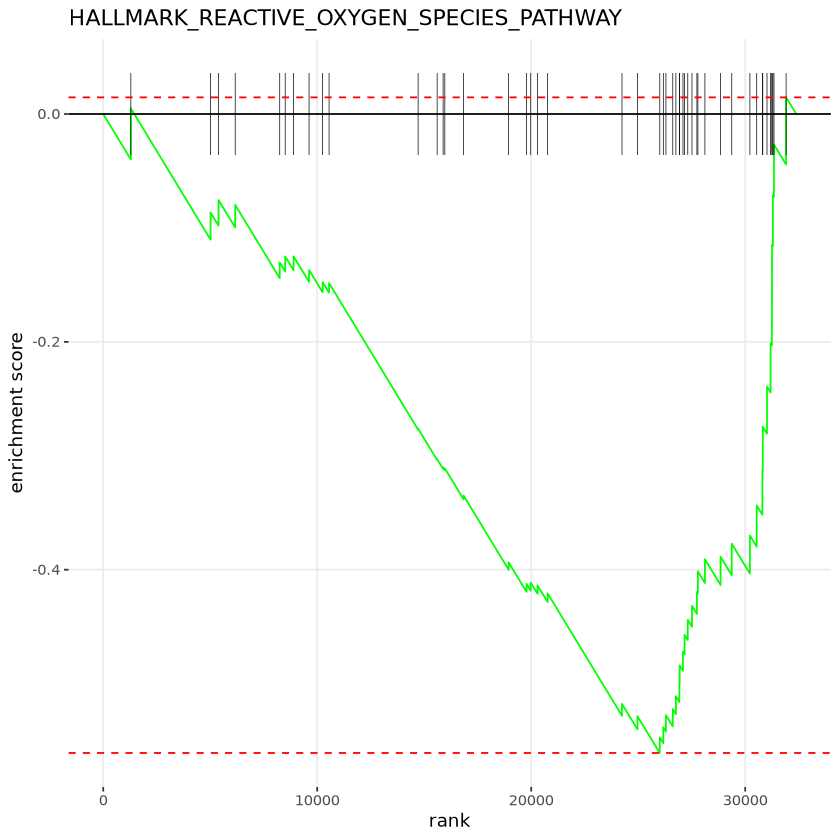

In [28]:
# z scores named numeric vector from earlier step
# Remove NA and infinite values
z_scores_clean <- z_scores[!is.na(z_scores) & is.finite(z_scores)]

# sort in decreasing order
ranked_genes <- sort(z_scores_clean, decreasing = TRUE)

# hallmark gene sets 
msigdb_sets <- msigdbr(species = "Homo sapiens", category = "H")  # H = Hallmark

# convert to list format
pathways_list <- split(msigdb_sets$gene_symbol, msigdb_sets$gs_name)
fgsea_res <- fgsea(pathways = pathways_list,
                   stats = ranked_genes,
                   minSize = 15,
                   maxSize = 500,
                   nperm = 10000)
# sort by significance
fgsea_res <- fgsea_res[order(fgsea_res$pval), ]

# top hits
head(fgsea_res)

# plot top pathway
plotEnrichment(pathways_list[[fgsea_res$pathway[1]]], ranked_genes) +
  labs(title = fgsea_res$pathway[1])


In [29]:
# take z scores from previous step and sort them, then get msigdb gene sets - hallmark paths
ranks <- sort(z_scores_clean, decreasing = TRUE)
pathways_df <- msigdbr(species = "Homo sapiens", category = "H")

# convert them to a list
pathways_list <- split(pathways_df$gene_symbol, pathways_df$gs_name)

# multilevel fgsea
fgsea_res <- fgseaMultilevel(pathways = pathways_list, stats = ranks)

# sort by padj
fgsea_res <- fgsea_res[order(fgsea_res$padj), ]

# filter for enrichment
fgsea_plot <- fgsea_res[abs(fgsea_res$NES) > 0.5, ]
fgsea_plot <- fgsea_plot[order(fgsea_plot$NES), ]

# create and save plot
fgsea_plot$label <- paste0(fgsea_plot$pathway, "\n(padj=", signif(fgsea_plot$padj, 2), ")")
my_plot <- ggplot(fgsea_plot, aes(x = reorder(pathway, NES), y = NES)) +
  geom_col(aes(fill = padj < 0.05)) +
  geom_text(aes(label = signif(padj, 2)), 
            hjust = -0.1,        
            size = 3, 
            color = "black") +
  coord_flip(clip = "off") +  
  labs(x = "Pathway", y = "Normalized Enrichment Score (NES)",
       title = "FGSEA: Patient pre-treatment vs CIC-DUX4 cohort") +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.margin = margin(5.5, 40, 5.5, 5.5) 
  )
# save plot
ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/fgsea_zscores_patient_FO_vs_cic_swissitaly.pdf", my_plot,
       width = 10, height = 8, device = cairo_pdf, dpi = 300)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (6.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways_list, stats = ranks):
“For some pathways, in reality P-values are less than 1e-50. You can set the `eps` argument to zero for better estimation.”


In [30]:
# filter significant genes by adjusted p value threshold
significant_genes <- names(p_adj)[p_adj < 0.05]
length(significant_genes) 

# df with the gene info viewing the top rows
sig_genes_df <- data.frame(
  gene = significant_genes,
  zscore = z_scores[significant_genes],
  p_adj = p_adj[significant_genes]
)
head(sig_genes_df)
# saving significant genes to a csv
write.csv(sig_genes_df, "/lustre/scratch126/cellgen/behjati/lr26/RNA/significant_genes_patient_Fo.csv", row.names = FALSE)

[1] 2239

,gene,zscore,p_adj
,<chr>,<dbl>,<dbl>
AACS,AACS,-5.408379,6.221809e-06
AASS,AASS,3.858603,3.616795e-03
ABCA10,ABCA10,3.187999,2.608177e-02
ABCA3,ABCA3,-4.732918,1.303020e-04
ABCB4,ABCB4,3.859760,3.613869e-03
ABCB9,ABCB9,4.883744,6.949806e-05


In [31]:
# here I am taking the top genes and seeing in which of the pathways they are
top_pathways <- head(fgsea_res$pathway[order(fgsea_res$padj)], 10)
leading_genes_list <- fgsea_res$leadingEdge[fgsea_res$pathway %in% top_pathways]
names(leading_genes_list) <- top_pathways

# saving all leading edge genes for top pathways
for (pw in top_pathways) {
  genes <- leading_genes_list[[pw]]
  write.csv(data.frame(gene = genes), paste0("/lustre/scratch126/cellgen/behjati/lr26/RNA/", pw, "_leadingEdge_genes_Fo.csv"), row.names = FALSE)
}


In [32]:
# I would like to see how many of the genes in the pathway that was enriched are actually present significantly expressed
# e.g. what is the overlap of the genes expressed with the pathway
top_genes <- significant_genes  # just gene names

overlap_summary <- list()

for (pw in names(leading_genes_list)) {
  leading_genes <- leading_genes_list[[pw]]
  
  overlap_genes <- intersect(top_genes, leading_genes)
  overlap_z <- z_scores[overlap_genes]
  
  overlap_summary[[pw]] <- data.frame(
    pathway = pw,
    num_leading = length(leading_genes),
    num_overlap = length(overlap_genes),
    sum_abs_z = sum(abs(overlap_z), na.rm = TRUE),
    mean_abs_z = mean(abs(overlap_z), na.rm = TRUE),
    genes_overlap = if(length(overlap_genes) > 0) paste(overlap_genes, collapse = ", ") else NA_character_
  )
}

overlap_df <- do.call(rbind, overlap_summary)
overlap_df <- overlap_df[order(-overlap_df$num_overlap), ]

write.csv(overlap_df, "/lustre/scratch126/cellgen/behjati/lr26/RNA/significant_genes_and_pathways_patient_Fo.csv", row.names = FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ stringr   1.5.1
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%()    masks IRanges::%within%()
✖ dplyr::collapse()        masks IRanges::collapse()
✖ dplyr::combine()         masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()           masks matrixStats::count()
✖ dplyr::desc()            masks IRanges::desc()
✖ tidyr::expand()          masks S4Vectors::expand()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::first()           masks S4Vectors::first()
✖ dplyr::lag()             masks stats::lag()
✖ BiocGenerics::Position() masks ggplot2::Position(), base::Position()
✖ purrr::reduce()          masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()          masks S4Vectors::rename()
✖ lubrida

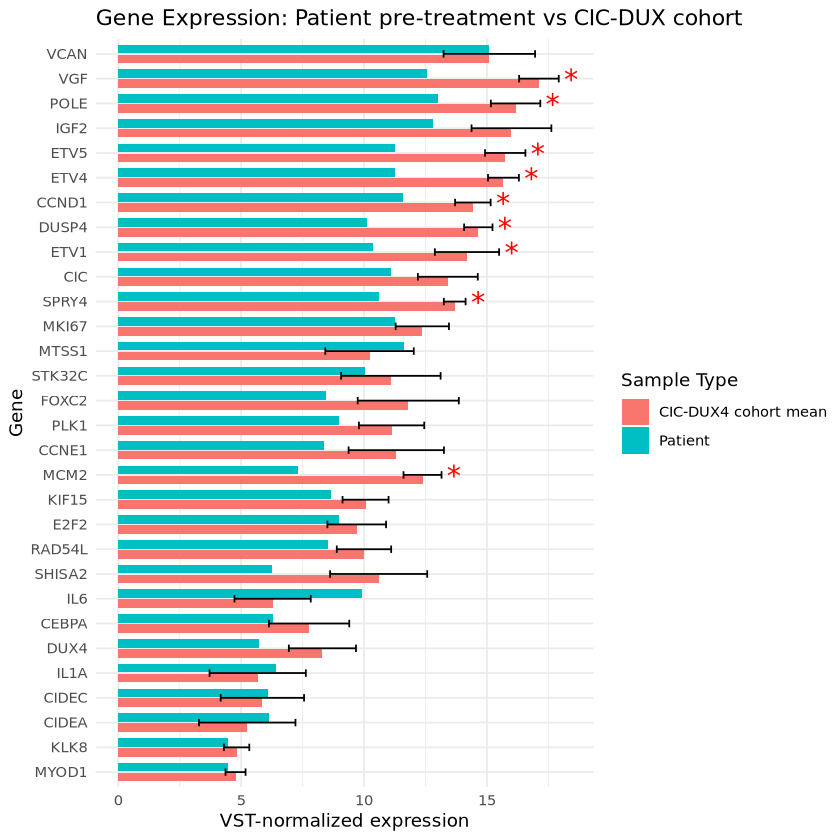

In [35]:
# here I am taking genes of interest, filtering for them in the vst matrix and then extracting their expression
genes_of_interest <- c("CIC", "DUX4", "MYOD1", "ETV1", "ETV4", 
                       "ETV5", "MKI67", "CEBPA", "SPRY4",
                       "MCM2", "E2F2", "PLK1", "KIF15", "IL1A", "KLK8",
                       "RAD54L", "CIDEA", "IL6", "CIDEC", "MTSS1",
                       "DUSP4", "POLE", "IGF2", "VCAN", "FOXC2",
                       "VGF", "SHISA2", "CCNE1", "STK32C", "CCND1")

genes_to_use <- genes_of_interest[genes_of_interest %in% rownames(vst_mat)]
cohort_expr <- vst_mat[genes_to_use, is_cic_dux4, drop = FALSE]
patient_expr <- vst_mat[genes_to_use, patient_id, drop = FALSE]

# expression for the patient and the cohort and computing the mean and standard deviation in the cohort
cohort_mean <- rowMeans(cohort_expr)
cohort_sd <- apply(cohort_expr, 1, sd)

# patient vector
patient_vec <- as.numeric(patient_expr)
names(patient_vec) <- rownames(patient_expr)

# z scores, p values and adjustment for the patient, using cohort mean and sd
z_scores <- (patient_vec - cohort_mean) / cohort_sd
p_values <- 2 * pnorm(-abs(z_scores))
p_adj <- p.adjust(p_values, method = "BH")

# summary dataframe for plotting
result_df <- data.frame(
  gene = names(z_scores),
  patient_expr = patient_vec,
  cohort_mean = cohort_mean,
  cohort_sd = cohort_sd,
  z_score = z_scores,
  p_value = p_values,
  p_adj = p_adj,
  signif_label = ifelse(p_adj < 0.05, "*", "")
)

# pivot for gg plot
plot_df <- result_df %>%
  pivot_longer(cols = c("patient_expr", "cohort_mean"),
               names_to = "sample_type", values_to = "expression") %>%
  mutate(sample_type = recode(sample_type,
                              patient_expr = "Patient",
                              cohort_mean = "CIC-DUX4 cohort mean"))

# plot with significance stars
ggplot(plot_df, aes(x = reorder(gene, expression), y = expression, fill = sample_type)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.7) +
  geom_errorbar(
  aes(x = gene, ymin = cohort_mean - cohort_sd, ymax = cohort_mean + cohort_sd),
  data = result_df,
  width = 0.3,
  position = position_dodge(width = 0.8),
  inherit.aes = FALSE
  ) +
  geom_text(
    data = result_df,
    aes(x = gene, y = pmax(patient_expr, cohort_mean) + (cohort_sd) + 0.5, label = signif_label),
    inherit.aes = FALSE,
    size = 6,
    color = "red"
  ) +
  coord_flip() +
  labs(
    title = "Gene Expression: Patient pre-treatment vs CIC-DUX cohort",
    x = "Gene",
    y = "VST-normalized expression",
    fill = "Sample Type"
  ) +
  theme_minimal()

# save plot
ggsave("/lustre/scratch126/cellgen/behjati/lr26/RNA/significant_genes_cicdux_vs_ourpatientFoithStars.pdf",
       width = 7, height = 6)

### I would have run the previous cells for the FT sample and the combined sample as well - e.g. gene expression, pathway enrichment (fgsea).

In [133]:
# combine by averaging their expression
vst_data <- vst(ddds, blind = TRUE)
vst_mat <- assay(vst_data)
patient_id <- c("our_patient", "our_patient_FO")

# safe matching by sample names
cond <- colData(vst_data)$Condition
sample_names <- colnames(vst_mat)

is_cic_dux4 <- cond == "CIC-DUX4 sarcoma" & sample_names != patient_id

# subset
cic_dux4_mat <- vst_mat[, is_cic_dux4]
patient_vec_combined <- rowMeans(vst_mat[, patient_id]) 

# compute mean and sd for the cic dux4 reference group
gene_sd <- apply(cic_dux4_mat, 1, sd)
gene_mean <- rowMeans(cic_dux4_mat)

# avoid division by zero
valid_genes <- gene_sd != 0

# z score for combined patient profile
z_scores <- (patient_vec_combined[valid_genes] - gene_mean[valid_genes]) / gene_sd[valid_genes]

# gene names
names(z_scores) <- rownames(vst_mat)[valid_genes]

# two sided p values and adjustment 
p_values <- 2 * pnorm(-abs(z_scores))
p_adj <- p.adjust(p_values, method = "BH")
names(p_adj) <- names(z_scores)

# top genes by significance
top_n <- min(50, length(p_adj))
top_genes <- names(sort(p_adj))[1:top_n]

# top genes by magnitude of z score
top_var_genes <- head(sort(abs(z_scores), decreasing = TRUE), 50)

# output
print(top_genes)
names(top_var_genes)

 [1] "A1BG"        "A1BG-AS1"    "A1CF"        "A2M"         "A2M-AS1"    
 [6] "A2ML1"       "A2ML1-AS1"   "A3GALT2"     "A4GALT"      "A4GNT"      
[11] "AAAS"        "AACS"        "AADAC"       "AADACL2"     "AADACL2-AS1"
[16] "AADACL4"     "AADAT"       "AAGAB"       "AAK1"        "AAMDC"      
[21] "AAMP"        "AANAT"       "AAR2"        "AARD"        "AARS1"      
[26] "AARS2"       "AARSD1"      "AASDH"       "AASDHPPT"    "AASS"       
[31] "AATBC"       "AATF"        "AATK"        "ABALON"      "ABAT"       
[36] "ABCA1"       "ABCA10"      "ABCA12"      "ABCA13"      "ABCA2"      
[41] "ABCA3"       "ABCA4"       "ABCA5"       "ABCA6"       "ABCA7"      
[46] "ABCA8"       "ABCA9"       "ABCA9-AS1"   "ABCB1"       "ABCB10"     


[1] "ABHD16B"       "LOC105370974"  "SYCP1"         "LOC124905025" 
 [5] "GCSAML-AS1"    "LOC128966685"  "SLX1B-SULT1A4" "KIFC1"        
 [9] "NR4A1AS"       "CSAG2"         "ANKRD30A"      "TEDC2"        
[13] "LOC100128002"  "LINC00993"     "CERS1"         "LOC100996696" 
[17] "LINC00882"     "NCAPH"         "KIF15"         "MCM10"        
[21] "UHRF1"         "ORC1"          "SPAG5"         "C14orf28"     
[25] "NSD2"          "RCOR3"         "CBX2"          "TREX2"        
[29] "TPX2"          "AUNIP"         "LOC93429"      "UTF1"         
[33] "E2F8"          "PLIN1"         "PIMREG"        "MYBL2"        
[37] "IGF2BP3"       "LOC124906725"  "BUB1B"         "HROB"         
[41] "CBS"           "HSD11B1-AS1"   "HASPIN"        "ARL13B"       
[45] "OBP2A"         "GCKR"          "TCIRG1"        "CAHM"         
[49] "ARHGAP11A"     "LOC101928230"